In [68]:
import re
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
from spacy.matcher import Matcher 
from spacy.tokens import Span 
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import tqdm
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pandas.core.dtypes.common import classes
from numpy import argmax 
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import *
from tensorflow import keras
import sklearn
from sklearn.model_selection import train_test_split
import nltk
import plotly.express as px
from sklearn.utils.class_weight import compute_sample_weight
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


pd.set_option('display.max_colwidth', 200)
%matplotlib inline


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [69]:
# from google.colab import drive
# drive.mount('/content/drive')

In [70]:
def extractWOrdsAndTags(data):
  words = list(set(data["Word"].values))
  words.append("ENDPAD")
  num_words = len(words)
  tags = list(set(data["Tag"].values))
  num_tags = len(tags)
  return words,num_words,tags,num_tags

def sentence_integrate(data):
  agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
  return data.groupby('Sentence #').apply(agg_func).tolist()

def get_key(val, my_dict):
    for key, value in my_dict.items():
        if val == value:
            return key

def makeSentenceOfSameLengthByPadding(max_len,sentences,num_words,word2idx,tag2idx):
  X = [[word2idx[w[0]] for w in s] for s in sentences]
  X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

  y = [[tag2idx[w[1]] for w in s] for s in sentences]
  y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["o"])
  return X,y

def changeYfromIntegerEncodedToOnceHotVector(y):
  final_y=[]
  for i in y:
    datat = i
    values = np.array(datat)
    # print(values)
    # integer encode
    integer_encoded = i
    # print(integer_encoded)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False,categories=[[0,1,2,3,4,5,6]])
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    final_y.append(onehot_encoded)
    # print(onehot_encoded)
  return np.array(final_y)

def generate_sample_weights(y_train,w):
  sentenceWeights = []
  for sentence in y_train:
    # print(sentence)
    wordWeights = []
    for word in sentence:
      wordWeights.append(w[argmax(word)])
    sentenceWeights.append(wordWeights)
  return np.array(sentenceWeights)

def readData(fileName):
  data = pd.read_csv(fileName)
  return data


## Reading the dataset

In [71]:
data = readData("wiki_sentences_abstract_1.csv")
# print(data.info())
# print(data.head(n=10))

## Data Preprocessing

In [72]:
fig = px.histogram(data[~data.Tag.str.contains("O")], x="Tag",color="Tag")
fig.show()

###As you can see above, the data here is very much imbalanced "o" class has samples of almost 7000 whereas classes have lesser representation.

In [73]:
#checking the null values in the dataframe
print(data.isnull().sum())

Sentence #    0
Word          0
Tag           0
dtype: int64


In [74]:
#Checking number of duplicate rows in the dataframe
print(f'Number of duplicate rows: {data.duplicated().sum()}')
#displaying the duplicate rows
print(data.loc[data.duplicated()])

Number of duplicate rows: 376
          Sentence #   Word    Tag
11       Sentence: 0     of      o
120      Sentence: 6     to  e-2-i
139      Sentence: 7     to      o
157      Sentence: 8      a      o
235     Sentence: 12     in  e-2-i
...              ...    ...    ...
14635  Sentence: 874  Suite  e-2-i
14694  Sentence: 877    the      o
14730  Sentence: 879    the  e-2-i
14750  Sentence: 880    the      o
14879  Sentence: 888    has      o

[376 rows x 3 columns]


In [75]:
data["Word"]=data["Word"].str.replace('[#,@,&,.,,]','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

The default value of regex will change from True to False in a future version.



In [76]:
nltk.download('stopwords')
#cleaning up the dataframe column text
#lowering the text to lower case
data['Word'] = data['Word'].str.lower()
print('Word lowered to lower case')
#stemming the Word
data['Word'] = data['Word'].apply(lambda x: ' '.join([PorterStemmer().stem(word) for word in x.split()]))
print('Word stemmed')
#removing stop words
data = data.loc[~((data['Word'].isin(stopwords.words('english'))) & (data['Tag'] == "o"))]
print('Stop words removed')
print(f'Data cleaning process completed')
#displaying the first 5 rows of the dataframe
data.head(5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Word lowered to lower case
Word stemmed
Stop words removed
Data cleaning process completed


,Sentence #,Word,Tag
0,Sentence: 0,the,e-1-b
1,Sentence: 0,convict,e-1-i
2,Sentence: 0,stem,r-b
4,Sentence: 0,feder,e-2-b
5,Sentence: 0,charg,e-2-i


In [77]:
#replacing all '' with nan in the dataframe column Word
data['Word'] = data['Word'].replace('', np.nan)
print('Replaced all empty strings with nan')
#totoal number of nan values in the dataframe
print(f'Total number of nan values: {data["Word"].isnull().sum()}')
#dropping all the nan values
data = data.dropna()
print('Dropped all nan values')
#displaying the first 5 rows of the dataframe
data.head(10)

Replaced all empty strings with nan
Total number of nan values: 1434
Dropped all nan values


,Sentence #,Word,Tag
0,Sentence: 0,the,e-1-b
1,Sentence: 0,convict,e-1-i
2,Sentence: 0,stem,r-b
4,Sentence: 0,feder,e-2-b
5,Sentence: 0,charg,e-2-i
7,Sentence: 0,consum,o
8,Sentence: 0,fraud,o
10,Sentence: 0,sale,o
12,Sentence: 0,phoni,o
13,Sentence: 0,infant,o


## Exploratory Data Analysis (EDA)

In [78]:
print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("What the dataset looks like:")
# Show the first 10 rows
data.head(n=5) 

Number of sentences:  897
Number of words in the dataset:  2967
Tags: ['o', 'e-1-b', 'r-b', 'e-2-i', 'e-1-i', 'r-i', 'e-2-b']
Number of Labels:  7
What the dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 0,the,e-1-b
1,Sentence: 0,convict,e-1-i
2,Sentence: 0,stem,r-b
4,Sentence: 0,feder,e-2-b
5,Sentence: 0,charg,e-2-i


In [79]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 2967
Unique tags in corpus: 7


In [80]:
tags = list(set(data["Tag"].values))
print(tags)
num_tags = len(tags)
print(num_tags)

['o', 'e-1-b', 'r-b', 'e-2-i', 'e-1-i', 'r-i', 'e-2-b']
7


In [81]:
fig = px.histogram(data[~data.Tag.str.contains("O")], x="Tag",color="Tag")
fig.show()

### After carefully removing stopwords corresponding to "o" class and removing special characters (like fulstop and comma) we have reduced the class imbalance quite a bit. The representation of "o" is reduced to 3000 from almost 7000.

In [82]:
sentences=sentence_integrate(data)
fig = px.histogram(pd.DataFrame([len(s) for s in sentences],columns=['length']),x="length",marginal='box')
fig.show()

# the distribution of length of sentence seems to have a normal distribution. THe maximum length of sentence is 20. We will need to make all the sentence of the size 21. This is done so that the sentences can be fed to he the recurrent neural networks in a batch. So this is an input constraint to recurrent networks.

## NER and RE using Bi-LSTM Network

In [83]:
words,num_words,tags,num_tags = extractWOrdsAndTags(data)
print(num_words)
print(words)
print(num_tags)
print(tags)

2968
['centr', 'result', 'king', 'tore', 'reploid', 'creativ', 'earlier', 'mean', 'sailboat', 'roger', 'guy', 'coal', 'adept', 'salwar', 'april', 'artist', 'short', 'magna', 'input', 'taser', '`', 'sec', '33', 'stage', 'lid', 'sharp', 'komo-tv', 'broke', 'litig', 'hearten', 'swanson', 'midnight', 'mine', 'deepli', 'studi', 'waist', 'behav', 'speaker', 'cemeteri', 'john', 'cottontail', 'parisian', 'blackburn', 'wipe', 'beyond', 'ride', 'identifi', 'licens', 'monday', 'capac', 'began', 'conflict', 'unlaw', 'acquir', 'tumbl', 'illeg', 'mccabe', 'attribut', 'divis', 'becam', 'similar', 'correspond', 'revco', 'clathrate-lik', 'premiership', 'penc', 'align', 'riot', 'close', 'day', 'suggest', '6-piec', 'burnout', 'halt', 'ladi', 'threaten', '80', 'what', 'mr/mr', 'trade', 'pound', 'promot', 'page', 'mid-2012', 'abbot', 'led', '3\\/4', 'wooden', 'believ', 'treasuri', 'avail', 'jiax', 'color', 'newsag', 'miscarri', 'dynasti', 'scout', 'actor', 'indefinit', 'knew', 'name', 'cgg', 'firefight', '

In [84]:
sentences=sentence_integrate(data)
print(sentences[0])

[('the', 'e-1-b'), ('convict', 'e-1-i'), ('stem', 'r-b'), ('feder', 'e-2-b'), ('charg', 'e-2-i'), ('consum', 'o'), ('fraud', 'o'), ('sale', 'o'), ('phoni', 'o'), ('infant', 'o'), ('appl', 'o'), ('juic', 'o'), ('1978', 'o'), ('1983', 'o')]


In [85]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
print(word2idx)
print(tag2idx)
get_key(515, word2idx)


{'centr': 1, 'result': 2, 'king': 3, 'tore': 4, 'reploid': 5, 'creativ': 6, 'earlier': 7, 'mean': 8, 'sailboat': 9, 'roger': 10, 'guy': 11, 'coal': 12, 'adept': 13, 'salwar': 14, 'april': 15, 'artist': 16, 'short': 17, 'magna': 18, 'input': 19, 'taser': 20, '`': 21, 'sec': 22, '33': 23, 'stage': 24, 'lid': 25, 'sharp': 26, 'komo-tv': 27, 'broke': 28, 'litig': 29, 'hearten': 30, 'swanson': 31, 'midnight': 32, 'mine': 33, 'deepli': 34, 'studi': 35, 'waist': 36, 'behav': 37, 'speaker': 38, 'cemeteri': 39, 'john': 40, 'cottontail': 41, 'parisian': 42, 'blackburn': 43, 'wipe': 44, 'beyond': 45, 'ride': 46, 'identifi': 47, 'licens': 48, 'monday': 49, 'capac': 50, 'began': 51, 'conflict': 52, 'unlaw': 53, 'acquir': 54, 'tumbl': 55, 'illeg': 56, 'mccabe': 57, 'attribut': 58, 'divis': 59, 'becam': 60, 'similar': 61, 'correspond': 62, 'revco': 63, 'clathrate-lik': 64, 'premiership': 65, 'penc': 66, 'align': 67, 'riot': 68, 'close': 69, 'day': 70, 'suggest': 71, '6-piec': 72, 'burnout': 73, 'halt

'strateg'

In [86]:
max_len = 21 #50
X,y = makeSentenceOfSameLengthByPadding(max_len,sentences,num_words,word2idx,tag2idx) # now the labels and inputs all are of the length max_len #21
final_y = changeYfromIntegerEncodedToOnceHotVector(y)
print(final_y.shape)


(897, 21, 7)


In [87]:
def classWeights(data):
  e_1_b= data[data['Tag'] == 'e-1-b']
  e_1_i= data[data['Tag'] == 'e-1-i']
  e_2_b= data[data['Tag'] == 'e-2-b']
  e_2_i= data[data['Tag'] == 'e-2-i']
  r_b= data[data['Tag'] == 'r-b']
  r_i= data[data['Tag'] == 'r-i']
  o= data[data['Tag'] == 'o']
  e_1_b_numpy = e_1_b['Tag'].to_numpy()
  e_1_i_numpy = e_1_i['Tag'].to_numpy()
  e_2_b_numpy = e_2_b['Tag'].to_numpy()
  e_2_i_numpy = e_2_i['Tag'].to_numpy()
  r_b_numpy = r_b['Tag'].to_numpy()
  r_i_numpy = r_i['Tag'].to_numpy()
  o_numpy = o['Tag'].to_numpy()
  all_together = np.concatenate((e_1_b_numpy, e_1_i_numpy,e_2_b_numpy,e_2_i_numpy,r_b_numpy,r_i_numpy,o_numpy))
  unique_classes = np.unique(all_together)
  print(unique_classes)
  class_weights = sklearn.utils.class_weight.compute_class_weight(
                                          class_weight = "balanced",
                                          classes = unique_classes,
                                          y = all_together                                                    
                                      )
  print(class_weights)
  return class_weights


In [88]:
classWeights(data)
class_weights = np.array([0.3189768626618552,2.393215480172002,0.5466550256466223,22.07539683,2.393215480172002,2.393215480172002,1.3358520757400658])
# class_weights = np.array([0.25734549,2.87981859,0.6978022,34.55782313,1.64935065,2.85714286,2.86843591])

['e-1-b' 'e-1-i' 'e-2-b' 'e-2-i' 'o' 'r-b' 'r-i']
[ 1.77193821  0.99775805  1.77193821  0.42272036  0.52804936  1.77193821
 22.07539683]


In [89]:

# # Compute weights
# weights = sklearn.utils.class_weight.compute_class_weight('balanced', unique_classes, all_together)
# print(weights)
# # data[~data.Tag.str.contains("O")]

# class_weights = dict(zip(unique_classes, class_weights))
# class_weights['r-i'] = 1.2
# class_weights
# keys = list(class_weights.keys())[:]
# # {'e-1-b': 6, 'e-1-i': 0, 'e-2-b': 1, 'e-2-i': 4, 'o': 3, 'r-b': 2, 'r-i': 5}

# for i in keys:
#   print(keys)
#   value = class_weights[i]
#   class_weights.pop(i, None)
#   newTag = tag2idx[i]
#   class_weights[newTag] = value
# classWeightList = list(class_weights.items())

In [90]:
x_train, x_test, y_train, y_test = train_test_split(X, final_y, test_size=0.2, random_state=1,shuffle=False)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((717, 21), (180, 21), (717, 21, 7), (180, 21, 7))

In [91]:
num_words

2968

In [92]:
outputDimention = 64
outputUnits = 7
model = keras.Sequential()
model.add(InputLayer((max_len)))
#model.add(Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len))
model.add(Embedding(input_dim=num_words, output_dim=outputDimention, input_length=max_len))
model.add(SpatialDropout1D(0.5))
model.add(
     Bidirectional(
         LSTM(
             units=outputDimention, 
             return_sequences=True,
             recurrent_dropout=0.5
              )
         )
     )
model.add(SpatialDropout1D(0.5))
# model.add(TimeDistributed(Dense(num_tags*8, activation='relu')))
model.add(TimeDistributed(Dense(num_tags, activation="softmax")))
# model.add(TimeDistributed(Dense(outputUnits,activation='softmax')))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 21, 64)            189952    
                                                                 
 spatial_dropout1d_11 (Spati  (None, 21, 64)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_6 (Bidirectio  (None, 21, 128)          66048     
 nal)                                                            
                                                                 
 spatial_dropout1d_12 (Spati  (None, 21, 128)          0         
 alDropout1D)                                                    
                                                                 
 time_distributed_6 (TimeDis  (None, 21, 7)            903       
 tributed)                                            

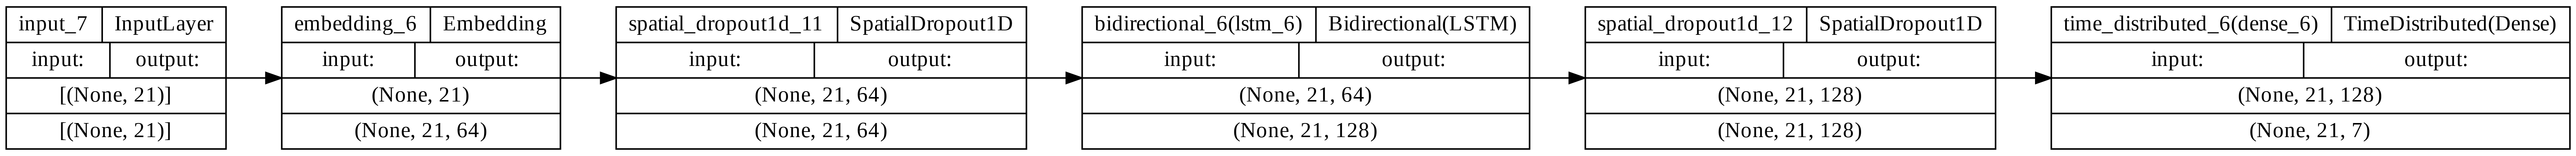

In [93]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='LR', expand_nested=True, dpi=300,
)

In [94]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"],
              sample_weight_mode="temporal"
              )

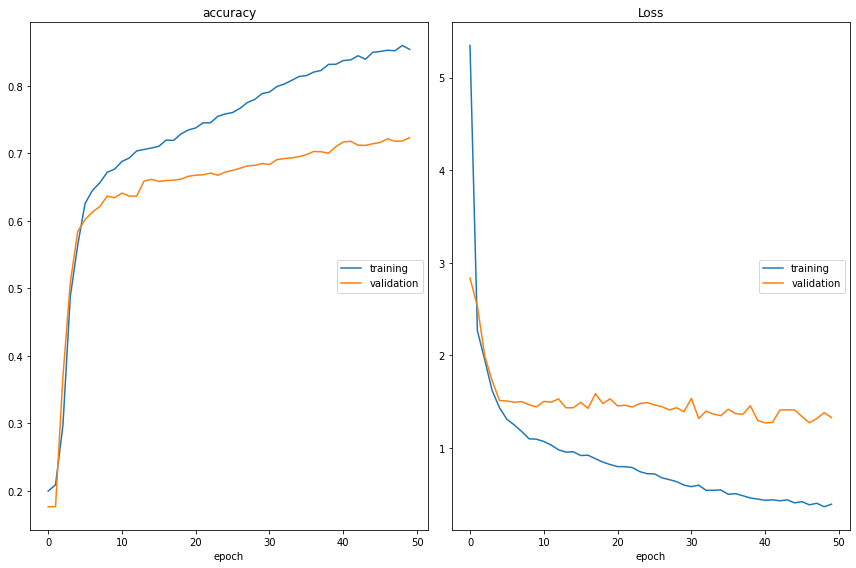

accuracy
	training         	 (min:    0.200, max:    0.860, cur:    0.854)
	validation       	 (min:    0.176, max:    0.723, cur:    0.723)
Loss
	training         	 (min:    0.364, max:    5.346, cur:    0.392)
	validation       	 (min:    1.270, max:    2.834, cur:    1.327)

Epoch 50: val_loss did not improve from 1.27006
45/45 [==============================] - 3s 65ms/step - loss: 0.3918 - accuracy: 0.8538 - val_loss: 1.3271 - val_accuracy: 0.7230
CPU times: user 3min 58s, sys: 11.1 s, total: 4min 9s
Wall time: 3min 4s


In [95]:
%%time

logdir="log/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='min', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping,tensorboard_callback]


history = model.fit(
    x=x_train,
    y=np.array(y_train,dtype = np.float32),
    validation_data=(x_test,y_test),
    batch_size=16, 
    epochs=50,
    callbacks=callbacks,
    verbose=1,
    sample_weight = generate_sample_weights(y_train, class_weights)
    
)

### In our training for training we see that the accuracy is increasing while the loss is decreasing. In case of validation set we do see a similar behavious up to a point. Further more the difference between the training and test lost starts to increase. 

###We need to ask ourselves the reason for this behavious of the curve?
###In my understanding the accuracy seems to improve overall but the predicted distribution seems to get worse as we train more and more.

###Is it oversimplification to say we are overfitting?
###Should we get more data?
###Should we get more features like POS?
###Should we try to decrease the number of parameters?
###What does this mean ... Do we have variance or do we have bias?
###Does picking up a better model expected to improve accuracy. Like if we are choosing Bi-LSTM over LSTM 


###IT seems The network is starting to learn patterns only relevant for the training set and not great for generalization.

###I sadly have no answer for whether or not this "overfitting" is a bad thing in this case: should we stop the learning once the network is starting to learn spurious patterns, even though it's continuing to learn useful ones along the way?

#Finally, I think this effect in our case of multi-class classification, the network at a given epoch might be severely overfit on some classes but still learning on others.

In [100]:
X_test_1_df = testingData(sentences_test_1, X_test_1)
X_test_1_df.head()
X_test_1_df.to_csv("Abs_1.csv")
X_test_2_df = testingData(sentences_test_2, X_test_2)
X_test_2_df.head()
X_test_2_df.to_csv("Abs_2.csv")
from sklearn.metrics import classification_report
print(classification_report(X_test_1_df["Tag"], X_test_1_df["Pred"]))
print(classification_report(X_test_2_df["Tag"], X_test_2_df["Pred"]))



              precision    recall  f1-score   support

       e-1-b       0.61      0.74      0.67        99
       e-1-i       0.00      0.00      0.00         0
       e-2-b       0.78      0.07      0.13        97
       e-2-i       0.00      0.00      0.00         0
           o       0.06      0.15      0.08        20
         r-b       0.14      0.03      0.05        97
         r-i       0.00      0.00      0.00        36

    accuracy                           0.25       349
   macro avg       0.23      0.14      0.13       349
weighted avg       0.43      0.25      0.24       349

              precision    recall  f1-score   support

       e-1-b       0.53      0.70      0.60       103
       e-1-i       0.17      0.49      0.25        73
       e-2-b       0.37      0.13      0.19       106
       e-2-i       0.45      0.32      0.38        78
           o       0.06      0.11      0.08        45
         r-b       0.18      0.08      0.12       106
         r-i       0.00 

In [ ]:
%reload_ext tensorboard

In [ ]:
print("Evaluate on train data")
results = model.evaluate(x_train, y_train, batch_size=128)
print("train loss: {} ".format(results[0]))
print("train accuracy: {} ".format(results[1]))

In [ ]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss: {} ".format(results[0]))
print("test accuracy: {} ".format(results[1]))

#pehle ka

In [98]:
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import stopwords
import numpy as np
def dataPreprocess(data):
  nltk.download('stopwords')
  #cleaning up the dataframe column text
  #lowering the text to lower case
  data['Word'] = data['Word'].str.lower()
  print('Word lowered to lower case')
  #removing fullstops, commas, and semi-colons
  data['Word'] = data['Word'].str.replace('[^a-zA-Z0-9]','')
  #stemming the Word
  data['Word'] = data['Word'].apply(lambda x: ' '.join([PorterStemmer().stem(word) for word in x.split()]))
  data = data.loc[~((data['Word'].isin(stopwords.words('english'))) & (data['Tag'] == "o"))]
  print('Word stemmed')
  #removing stop words
  # data['Word'] = data['Word'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words('english'))]))
  # print('Stop words removed')
  print(f'Data cleaning process completed')
  #displaying the first 5 rows of the dataframe
  data.head(10)
  #replacing all '' with nan in the dataframe column Word
  data['Word'] = data['Word'].replace('', np.nan)
  print('Replaced all empty strings with nan')
  #totoal number of nan values in the dataframe
  print(f'Total number of nan values: {data["Word"].isnull().sum()}')
  #dropping all the nan values
  data = data.dropna()
  print('Dropped all nan values')
  return data

In [99]:
### Testing the Abstract 1 and 2
test_1 = pd.read_csv('wiki_sentences_abstract_2.csv')
test_2 = pd.read_csv('wiki_sentences_abstract_3.csv')
test_1 = dataPreprocess(test_1)
# print(test_1.head())
test_2 = dataPreprocess(test_2)
# print(test_2.head())
#integrating the data
sentences_test_1 =sentence_integrate(test_1)
sentences_test_2 =sentence_integrate(test_2)
# print(sentences_test_1[:10])
# print(sentences_test_2[:10])
max_len = 21 #50
X_test_1 = [[word2idx[w[0]] if w[0] in word2idx else word2idx['ENDPAD'] for w in s] for s in sentences_test_1]
X_test_1 = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)
X_test_2 = [[word2idx[w[0]] if w[0] in word2idx else word2idx['ENDPAD'] for w in s] for s in sentences_test_2]
X_test_2 = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)
# print(X_test_1[:2])
# print(X_test_2[:2])
def testingData(original, xTest):
  finalList = []
  for sent_no, org, to_test in zip(range(len(original)), original, xTest):
    p = model.predict(np.array([to_test]))
    p = np.argmax(p, axis=-1)
    # print(p)
    for w, pred in zip(org, p[0]):
      # print(tags[pred])
      tempList = []
      tempList.append(sent_no)
      tempList.append(w[0])
      tempList.append(w[1])
      tempList.append(tags[pred])
      finalList.append(tempList)
  # print(classification_report(finalList["Tag"], finalList["Pred"]))
  return pd.DataFrame(finalList, columns=["Sentence #", "Word", "Tag", "Pred"])
# X_test_1_df = testingData(sentences_test_1, X_test_1)
# X_test_1_df.head()
# X_test_1_df.to_csv("Abs_1.csv")
# X_test_2_df = testingData(sentences_test_2, X_test_2)
# X_test_2_df.head()
# X_test_2_df.to_csv("Abs_2.csv")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Word lowered to lower case
Word stemmed
Data cleaning process completed
Replaced all empty strings with nan
Total number of nan values: 10
Dropped all nan values
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Word lowered to lower case
Word stemmed
Data cleaning process completed
Replaced all empty strings with nan
Total number of nan values: 72
Dropped all nan values


#baad ka

In [101]:
a = model.predict(np.array([x_test[0]]))

In [129]:
i = np.random.randint(0, x_test.shape[0])
#i = 19
print("This is sentence:",i)
#print(x_test[i].type)
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
print(x_test[i])
print(p[0])
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print(words[39])
print("-" *30)
for w, true, pred in zip(x_test[i], y_test[i], p[0]):
    # print(words[w-1])
    # print(tags[argmax(true)])
    # get_key(515, word2idx)
#     # print(tags[pred])
    # print(true)
    print("{:15}{}\t{}".format(words[w-1], tags[argmax(true)], tags[pred]))
#     # print("{:15}{}\t{}".format(get_key(w, word2idx), tags[argmax(true)], tags[pred]))

This is sentence: 29
[ 365 1250  226  361 2949  287 2566 1250 1986 2544 2959 2227 2788 2967
 2967 2967 2967 2967 2967 2967 2967]
[1 4 4 4 4 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0]
Word           True 	 Pred

john
------------------------------
web-foot       o	e-1-b
gecko          o	e-1-i
genu           o	e-1-i
palmatogecko   o	e-1-i
two            e-1-b	e-1-i
speci          e-1-i	o
of             e-1-i	e-2-i
gecko          e-1-i	e-2-i
live           r-b	e-2-i
in             e-2-b	e-2-i
the            e-2-i	e-2-i
namib          e-2-i	e-2-i
desert         e-2-i	e-2-i
scieszka       o	o
scieszka       o	o
scieszka       o	o
scieszka       o	o
scieszka       o	o
scieszka       o	o
scieszka       o	o
scieszka       o	o


In [126]:
def convert_to_string(lst):
    str1 = ""
    for ele in lst:
        str1 += ele
    return str1

nnRelations = []
nnEntities = []
print(X.shape)
for i in X:
  p = model.predict(np.array([i]))
  p = np.argmax(p, axis=-1)
  en=[]
  rl=[]
  for w, pred in zip(i, p[0]):
    try:
      #if tags[pred] is 'e-1'
      if tags[pred] == 'e-1':
        en.append(words[w-1])
        #if tags[pred] is 'e-2'
        if tags[pred] == 'e-2':
          en.append(words[w-1])
          #if tags[pred] is 'r-b'
          if tags[pred] == 'r-b':
            rl.append(words[w-1])
            if tags[pred] == 'r-i':
              rl.append(words[w-1])
          else:
            continue
        else:
          continue
        nnRelations.append(convert_to_string(rl))
        nnEntities.append(en)
      else:
        continue
    except:    
      print()

(897, 21)


KeyboardInterrupt: ignored

In [ ]:
source = []
target = []

for i in nnEntities:
  try:
    source.append(i[0])
    target.append(i[1])
  except:
    source.append("")
    target.append("")

maxLen = min(len(source), len(target), len(nnRelations))
print(maxLen)
source=source[:maxLen]
target=target[:maxLen]
nnRelations[:maxLen]

kg_df2 = pd.DataFrame({'source':source, 'target':target, 'edge':nnRelations})

## Using pretrained-embedding

In [ ]:
# import gensim.downloader as api

# wv = api.load('word2vec-google-news-300')
# wordembeddings = wv
# df = readData("wiki_sentences_abstract_1.csv")
# from tensorflow.keras.preprocessing.text import Tokenizer
# df = preprocessing(df)
# tokenizer = Tokenizer(filters='')

# def makeSentenceOfSameLengthByPadding(max_len,sentences,num_words,word2idx,tag2idx):
#   X = [[word2idx[w[0]] for w in s] for s in sentences]#[[tokenizer.texts_to_sequences([w[0]])[0][0] for w in s] for s in sentences]
#   X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

#   y = [[tag2idx[w[1]] for w in s] for s in sentences]
#   y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["o"])
#   return X,y



  
# sentences=sentence_integrate(df)
# words,num_words,tags,num_tags = extractWOrdsAndTags(data)
# word2idx = {w: i + 1 for i, w in enumerate(words)}
# tag2idx = {t: i for i, t in enumerate(tags)}
# max_len = np.max(np.array([len(i) for i in sentences])) + 1
# X,y = makeSentenceOfSameLengthByPadding(max_len,sentences,num_words,word2idx,tag2idx) # now the labels and inputs all are of the length max_len #21
# final_y = changeYfromIntegerEncodedToOnceHotVector(y)

# unique_words = len(tokenizer.word_index)
# total_words = unique_words + 1
# skipped_words = 0
# embedding_dim = 300
# embedding_matrix = np.zeros((total_words, embedding_dim))
# for word,index in tokenizer.word_index.items():
#   try:
#     embedding_vector = wordembeddings[word]
#   except:
#     skipped_words +=1
#   if embedding_vector is not None:
#     embedding_matrix[index] = embedding_vector
# print("Embedding shape",embedding_matrix.shape)

# embedding_layer = Embedding(total_words, embedding_dim, weights = [embedding_matrix], input_length = max_len,trainable = False)
# outputDimention = 256
# outputUnits = 7
# model = keras.Sequential()
# # model.add(InputLayer((max_len)))
# #model.add(Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len))
# model.add(embedding_layer)
# model.add(SpatialDropout1D(0.5))
# model.add(
#      Bidirectional(
#          LSTM(
#              units=outputDimention, 
#              return_sequences=True,
#              recurrent_dropout=0.5
#               )
#          )
#      )


# # model.add(TimeDistributed(Dense(outputUnits,activation='softmax')))
# model.add(TimeDistributed(Dense(num_tags*8, activation='relu')))
# model.add(TimeDistributed(Dense(num_tags, activation="softmax")))

# model.summary()
# x_train, x_test, y_train, y_test = train_test_split(X, final_y, test_size=0.25, random_state=1,shuffle=False)
# x_train.shape,x_test.shape,y_train.shape,y_test.shape

In [ ]:
data6 = readData("wiki_sentences_abstract_1.csv")

In [ ]:
data6 = preprocessing(data6)

In [ ]:
!wget --no-check-certificate \
    http://nlp.stanford.edu/data/glove.6B.zip \
    -O /content/glove.6B.zip
!pip install zipfile36
import sys
if sys.version_info >= (3, 6):
    import zipfile
else:
    import zipfile36 as zipfile
with zipfile.ZipFile('glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/glove')

embeddings_index = {}
f = open('/content/glove/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# Hyperparams for training

BATCH_SIZE = 32
EPOCHS = 5
MAX_LEN = 75
EMBEDDING = 20

import tqdm
def sentence_integrate(data):
  agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(), 
                                                  s["Tag"].values.tolist())]
  return data.groupby('Sentence #').apply(agg_func).tolist()
sentences=sentence_integrate(df)



words = list(set(data["Word"].values))

#words = list(set(data["Word"].values+'_'+data["POS"].values))
#defining the padding
words.append("ENDPAD")
num_words = len(words)
print(num_words)

#extracting the unique tags
tags = list(set(data["Tag"].values))
print(tags)
num_tags = len(tags)
print(num_tags)


In [ ]:
 word2idx.get('conviction')

In [ ]:


#integrating the words with tags for better processing
import tqdm
def sentence_integrate(data):
  agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
  return data.groupby('Sentence #').apply(agg_func).tolist()

  #integrating the data
sentences=sentence_integrate(data6)

word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

def get_key(val, my_dict):
    for key, value in my_dict.items():
        if val == value:
            return key
get_key(515, word2idx)

from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 100 #50

X = [[word2idx[w[0].lower()] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["o"])

embedding_matrix = np.zeros((len(word2idx) + 1, max_len))
for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

model = keras.Sequential()
model.add(InputLayer((max_len)))
#model.add(Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len))
model.add(Embedding(input_dim=len(word2idx)+1, output_dim=max_len, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(SpatialDropout1D(0.5))
model.add( LSTM(units=50, return_sequences=True, recurrent_dropout=0.5))
model.add(TimeDistributed(Dense(num_tags*8, activation='relu')))
model.add(TimeDistributed(Dense(num_tags, activation="softmax")))

model.summary()


In [ ]:
embedding_matrix = np.zeros((len(word2idx) + 1, max_len))
for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector